# Model 4: Discovery Trigger Probability

**Purpose:** Predict which maps are likely to hit Discovery placement

**Why this matters:**
- Discovery placement = 10-100x CCU boost
- Helps clients optimize for Discovery eligibility
- Shows "how close" a map is to Discovery

**Target variable:**
- `in_discovery` (binary: yes/no)

**This is a CLASSIFICATION problem (not regression)!**

## 1. Import Libraries

In [1]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
import joblib

sns.set_style('whitegrid')
print("✅ Libraries imported")

✅ Libraries imported


## 2. Load Map Data

In [2]:
DATA_DIR = Path('../data/raw')
map_files = list(DATA_DIR.glob('map_*.json'))
print(f"📊 Found {len(map_files)} map files")

📊 Found 962 map files


## 3. Feature Extraction

In [3]:
def extract_discovery_features(map_file):
    """Extract features for Discovery prediction"""
    try:
        with open(map_file, 'r') as f:
            data = json.load(f)
        
        map_data = data['map_data']
        creator = map_data.get('creator', {})
        
        # Target: Is map in Discovery?
        in_discovery = 1 if map_data.get('state') == 'in_discovery' else 0
        
        # Must have CCU data
        current_ccu = map_data.get('lastSyncCcu', 0)
        if current_ccu == 0:
            return None
        
        # Time-series features
        stats_7d = data.get('stats_7d', {})
        if not stats_7d.get('success'):
            return None
        
        ccu_values = stats_7d.get('data', {}).get('stats', [])
        if len(ccu_values) < 50:
            return None
        
        ccu_arr = np.array(ccu_values)
        avg_ccu = np.mean(ccu_arr)
        peak_ccu = np.max(ccu_arr)
        ccu_growth = (ccu_arr[-24:].mean() - ccu_arr[:24].mean()) / max(ccu_arr[:24].mean(), 1)
        ccu_volatility = np.std(ccu_arr) / max(np.mean(ccu_arr), 1)
        
        # Map age
        try:
            published = datetime.fromisoformat(map_data.get('published', '').replace('Z', '+00:00'))
            last_sync = datetime.fromisoformat(map_data.get('lastSyncDate', '').replace('Z', '+00:00'))
            map_age_days = (last_sync - published).days
        except:
            map_age_days = 0
        
        # Tags
        tags = map_data.get('tags', [])
        primary_tag = tags[0] if tags else 'unknown'
        
        # Creator metrics
        creator_followers = creator.get('lookup_follower_count', 0)
        
        return {
            'map_code': map_data.get('id'),
            'name': map_data.get('name', 'Unknown'),
            'type': map_data.get('type', 'unknown'),
            'primary_tag': primary_tag,
            'num_tags': len(tags),
            'max_players': map_data.get('max_players', 0),
            'xp_enabled': 1 if map_data.get('xp_enabled') else 0,
            'creator_followers': creator_followers,
            'version': map_data.get('version', 0),
            'map_age_days': map_age_days,
            'avg_ccu_7d': avg_ccu,
            'peak_ccu_7d': peak_ccu,
            'ccu_growth_rate': ccu_growth,
            'ccu_volatility': ccu_volatility,
            'current_ccu': current_ccu,
            'in_discovery': in_discovery,  # TARGET
        }
    except:
        return None

print("✅ Feature extraction defined")

✅ Feature extraction defined


In [4]:
# Process all maps
print("🔄 Extracting features...")
features_list = []

for i, map_file in enumerate(map_files):
    if i % 100 == 0:
        print(f"   {i}/{len(map_files)}...", end='\r')
    
    features = extract_discovery_features(map_file)
    if features:
        features_list.append(features)

df = pd.DataFrame(features_list)
print(f"\n✅ Processed {len(df)} maps")

🔄 Extracting features...
   900/962...
✅ Processed 953 maps


## 4. Class Distribution Analysis

In [5]:
print("📊 Discovery Status Distribution:")
print("="*70)
print(df['in_discovery'].value_counts())
print(f"\nDiscovery rate: {df['in_discovery'].mean() * 100:.1f}%")

# Check if we have enough Discovery maps
num_discovery = df['in_discovery'].sum()
if num_discovery < 10:
    print(f"\n⚠️  WARNING: Only {num_discovery} Discovery maps!")
    print("   Model may struggle with class imbalance.")
else:
    print(f"\n✅ Sufficient Discovery examples: {num_discovery}")

📊 Discovery Status Distribution:
in_discovery
1    857
0     96
Name: count, dtype: int64

Discovery rate: 89.9%

✅ Sufficient Discovery examples: 857


## 5. Encode Features

In [6]:
type_encoder = LabelEncoder()
tag_encoder = LabelEncoder()

df['type_encoded'] = type_encoder.fit_transform(df['type'])
df['tag_encoded'] = tag_encoder.fit_transform(df['primary_tag'])

# Feature columns
feature_columns = [
    'type_encoded',
    'tag_encoded',
    'num_tags',
    'max_players',
    'xp_enabled',
    'creator_followers',
    'version',
    'map_age_days',
    'avg_ccu_7d',
    'peak_ccu_7d',
    'ccu_growth_rate',
    'ccu_volatility',
    'current_ccu'
]

X = df[feature_columns]
y = df['in_discovery']

print(f"✅ Features prepared")
print(f"   Shape: {X.shape}")

✅ Features prepared
   Shape: (953, 13)


## 6. Train/Test Split

In [7]:
# Stratified split (maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("📊 Data Split:")
print(f"   Training: {len(X_train)} maps")
print(f"   Testing:  {len(X_test)} maps")
print(f"   Train Discovery rate: {y_train.mean()*100:.1f}%")
print(f"   Test Discovery rate:  {y_test.mean()*100:.1f}%")

📊 Data Split:
   Training: 762 maps
   Testing:  191 maps
   Train Discovery rate: 89.9%
   Test Discovery rate:  90.1%


## 7. Train Models

In [8]:
print("="*70)
print("🤖 TRAINING CLASSIFICATION MODELS")
print("="*70)

# Model 1: Random Forest Classifier
print("\n🌲 Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"   Accuracy: {acc_rf:.3f}, Precision: {prec_rf:.3f}, Recall: {rec_rf:.3f}")
print(f"   F1: {f1_rf:.3f}, AUC: {auc_rf:.3f}")

# Model 2: Gradient Boosting
print("\n🚀 Training Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

acc_gb = accuracy_score(y_test, y_pred_gb)
prec_gb = precision_score(y_test, y_pred_gb)
rec_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
auc_gb = roc_auc_score(y_test, y_proba_gb)

print(f"   Accuracy: {acc_gb:.3f}, Precision: {prec_gb:.3f}, Recall: {rec_gb:.3f}")
print(f"   F1: {f1_gb:.3f}, AUC: {auc_gb:.3f}")

# Model 3: Logistic Regression
print("\n📈 Training Logistic Regression...")
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

print(f"   Accuracy: {acc_lr:.3f}, Precision: {prec_lr:.3f}, Recall: {rec_lr:.3f}")
print(f"   F1: {f1_lr:.3f}, AUC: {auc_lr:.3f}")

🤖 TRAINING CLASSIFICATION MODELS

🌲 Training Random Forest...
   Accuracy: 0.901, Precision: 0.942, Recall: 0.948
   F1: 0.945, AUC: 0.868

🚀 Training Gradient Boosting...
   Accuracy: 0.901, Precision: 0.918, Recall: 0.977
   F1: 0.946, AUC: 0.830

📈 Training Logistic Regression...
   Accuracy: 0.759, Precision: 0.944, Recall: 0.779
   F1: 0.854, AUC: 0.778


## 8. Compare Models

In [9]:
print("\n" + "="*70)
print("📊 MODEL COMPARISON")
print("="*70)

results = pd.DataFrame([
    {'Model': 'Random Forest', 'Accuracy': acc_rf, 'Precision': prec_rf, 
     'Recall': rec_rf, 'F1': f1_rf, 'AUC': auc_rf},
    {'Model': 'Gradient Boosting', 'Accuracy': acc_gb, 'Precision': prec_gb, 
     'Recall': rec_gb, 'F1': f1_gb, 'AUC': auc_gb},
    {'Model': 'Logistic Regression', 'Accuracy': acc_lr, 'Precision': prec_lr, 
     'Recall': rec_lr, 'F1': f1_lr, 'AUC': auc_lr}
])

print("\n" + results.to_string(index=False))

# Best model by AUC (most important for probability predictions)
best_idx = results['AUC'].idxmax()
best_model_name = results.loc[best_idx, 'Model']
best_auc = results.loc[best_idx, 'AUC']

if best_model_name == 'Random Forest':
    best_model = rf_model
    best_predictions = y_pred_rf
    best_proba = y_proba_rf
elif best_model_name == 'Gradient Boosting':
    best_model = gb_model
    best_predictions = y_pred_gb
    best_proba = y_proba_gb
else:
    best_model = lr_model
    best_predictions = y_pred_lr
    best_proba = y_proba_lr

print(f"\n🏆 Best Model: {best_model_name} (AUC = {best_auc:.3f})")


📊 MODEL COMPARISON

              Model  Accuracy  Precision   Recall       F1      AUC
      Random Forest  0.900524   0.942197 0.947674 0.944928 0.867503
  Gradient Boosting  0.900524   0.918033 0.976744 0.946479 0.829865
Logistic Regression  0.759162   0.943662 0.779070 0.853503 0.778458

🏆 Best Model: Random Forest (AUC = 0.868)


## 9. Confusion Matrix

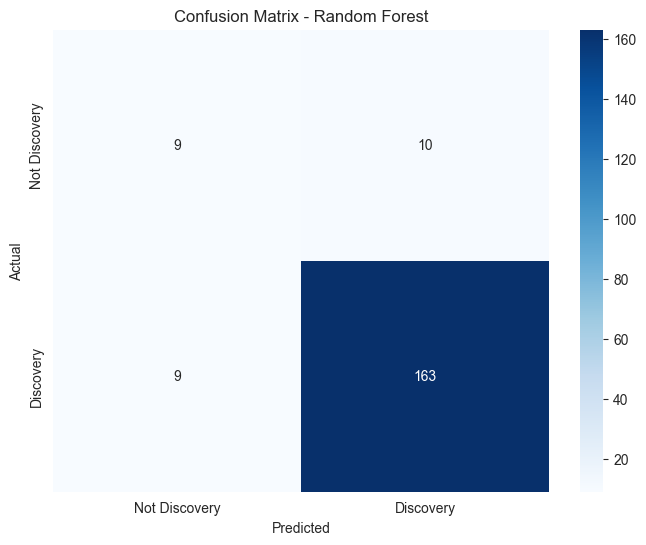


Classification Report:
               precision    recall  f1-score   support

Not Discovery       0.50      0.47      0.49        19
    Discovery       0.94      0.95      0.94       172

     accuracy                           0.90       191
    macro avg       0.72      0.71      0.72       191
 weighted avg       0.90      0.90      0.90       191



In [10]:
cm = confusion_matrix(y_test, best_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Discovery', 'Discovery'],
            yticklabels=['Not Discovery', 'Discovery'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, best_predictions, 
                          target_names=['Not Discovery', 'Discovery']))

## 10. Feature Importance

📊 TOP 10 FEATURES FOR DISCOVERY:
          feature  importance
      peak_ccu_7d    0.241497
       avg_ccu_7d    0.191258
      current_ccu    0.152711
      tag_encoded    0.074699
   ccu_volatility    0.064489
  ccu_growth_rate    0.062045
creator_followers    0.056505
     map_age_days    0.055002
          version    0.041976
     type_encoded    0.026717


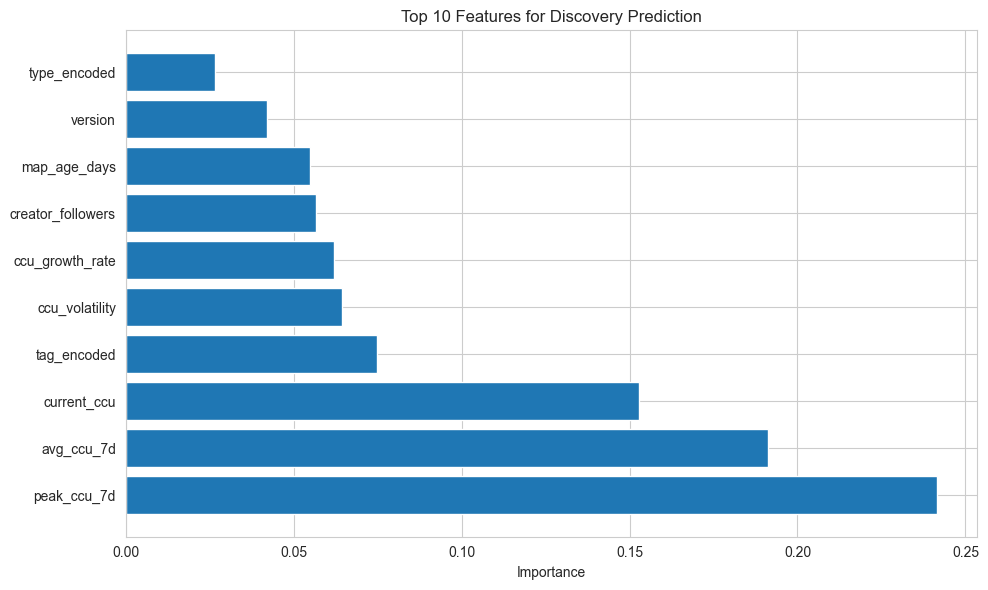

In [11]:
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("📊 TOP 10 FEATURES FOR DISCOVERY:")
    print("="*70)
    print(importance_df.head(10).to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'][:10], importance_df['importance'][:10])
    plt.xlabel('Importance')
    plt.title('Top 10 Features for Discovery Prediction')
    plt.tight_layout()
    plt.show()

## 11. Save Model

In [12]:
models_dir = Path('../data/models')
models_dir.mkdir(exist_ok=True)

# Save model
joblib.dump(best_model, models_dir / 'discovery_predictor.pkl')
print(f"✅ Model saved: {models_dir / 'discovery_predictor.pkl'}")

# Save encoders
encoders = {
    'type_encoder': type_encoder,
    'tag_encoder': tag_encoder,
    'feature_columns': feature_columns,
    'model_name': best_model_name
}
joblib.dump(encoders, models_dir / 'discovery_encoders.pkl')
print(f"✅ Encoders saved")

# Save metadata
metadata = {
    'model_type': 'discovery_classification',
    'best_model': best_model_name,
    'accuracy': float(results.loc[best_idx, 'Accuracy']),
    'precision': float(results.loc[best_idx, 'Precision']),
    'recall': float(results.loc[best_idx, 'Recall']),
    'f1_score': float(results.loc[best_idx, 'F1']),
    'auc': float(best_auc),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'discovery_rate': float(y.mean()),
    'date_trained': datetime.now().isoformat()
}
with open(models_dir / 'discovery_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata saved")

✅ Model saved: ../data/models/discovery_predictor.pkl
✅ Encoders saved
✅ Metadata saved


## 12. Summary

In [13]:
print("\n" + "="*70)
print("🎉 DISCOVERY PREDICTOR TRAINING COMPLETE!")
print("="*70)
print(f"\n✅ Best Model: {best_model_name}")
print(f"✅ AUC: {best_auc:.3f}")
print(f"✅ F1 Score: {results.loc[best_idx, 'F1']:.3f}")
print(f"✅ Training samples: {len(X_train)}")

print("\n💡 HOW TO USE:")
print("   Input: Map features + CCU metrics")
print("   Output: Discovery probability (0-100%)")
print("   Value: Shows how close a map is to Discovery!")

if best_auc >= 0.8:
    print(f"\n🎯 EXCELLENT! AUC = {best_auc:.3f} is highly predictive!")
elif best_auc >= 0.7:
    print(f"\n👍 GOOD! AUC = {best_auc:.3f} is useful")
else:
    print(f"\n⚠️  AUC = {best_auc:.3f} - may need more features")

print("="*70)


🎉 DISCOVERY PREDICTOR TRAINING COMPLETE!

✅ Best Model: Random Forest
✅ AUC: 0.868
✅ F1 Score: 0.945
✅ Training samples: 762

💡 HOW TO USE:
   Input: Map features + CCU metrics
   Output: Discovery probability (0-100%)
   Value: Shows how close a map is to Discovery!

🎯 EXCELLENT! AUC = 0.868 is highly predictive!
